# Artificial Neural Networks and Deep Learning

---

## Extra Material: Zero-Shot Image Classification via CLIP

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import other libraries
from transformers import pipeline
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image, ImageDraw
from matplotlib import cm
import requests

### **CLIP (aka Contrastive Language–Image Pre-training)**

CLIP is a model proposed by OpenAI designed to predict which N × N potential (image, text) pairings within the batch are actual matches. To achieve this, CLIP establishes a multi-modal embedding space through the joint training of an image encoder and text encoder.

[Learning Transferable Visual Models From Natural Language Supervision](https://proceedings.mlr.press/v139/radford21a) - Proceedings of the 38th International Conference on Machine Learning, 2021


#### **CLIP Ingredients**

In order to build a CLIP-like model, the following ingredients are required:
*   Text Encoder - Transformer
*   Image Encoder - ResNet or Vision Transformer
*   A wide dataset composed of Text and Image pairs (400 million samples in the original implementation)

<img src="https://cdn.sanity.io/images/vr8gru94/production/46b85e640919609e98a79a8142a1181e57d12799-2803x1335.png" width="700">

#### **CLIP Training**

The CLIP loss aims to maximize the cosine similarity between the image and text embeddings for the $N$ genuine pairs in the batch while minimizing the cosine similarity for the $N^2 - N$ incorrect pairings.

Let $\mathbf{I} \in \mathbb{R}^{n \times h \times w \times c}$ and $\mathbf{T} \in \mathbb{R}^{n \times l}$ be the image dataset and the corresponding text caption dataset respectively, and $E_{i}$ be the image encoder while $E_{t}$ the text encoder.

It is possible to define the image and the text embeddings as:

$\mathbf{e}_{i}=E_{i}(\mathbf{I})$

$\mathbf{e}_{t}=E_{t}(\mathbf{T})$

These embeddings are subsequently projected into a new space through two dense layers with weight matrices $\mathbf{W}_i$ and $\mathbf{W}_t$ via the following normalised forwarding steps:

$\mathbf{l}_{i}=||\mathbf{e}_{i}\mathbf{W}_i||_2$

$\mathbf{l}_{t}=||\mathbf{e}_{t}\mathbf{W}_t||_2$

At this point the scaled pairwise similarity matrix can be computed and scaled with the temperature factor $t=0.07$:

$\hat{\textbf{y}}=\mathbf{l}_{i}\mathbf{l}_{t}^T\cdot e^t$

The last step is to calculate the final loss as the average of the cross-entropies between both the image and text axis of similarity matrix and a linear space of equal size $\textbf{y}=\{0,1,...,n-1\}$. The final loss is defines as:

$\mathcal{L} = \frac{\mathcal{L}_{ce}(\textbf{y},\hat{\textbf{y}})+\mathcal{L}_{ce}(\textbf{y},\hat{\textbf{y}}^T)}{2}$
    
The goal is to minimize this loss, enhancing agreement between correctly paired image and text embeddings.

<img src="https://cdn.sanity.io/images/vr8gru94/production/b7e270212d57ff9dd2da60f8fac00c6dddef9c3a-1165x671.png" width="700">

#### **CLIP Zero-Shot Image Classification**

CLIP works as a zero-shot classifier by comparing images to text descriptions. It can classify images by matching them to the most relevant text, even without training specifically for that task.

<img src="https://cdn.sanity.io/images/vr8gru94/production/d9a6ebbc9a2f3334ec57a6b54d90155043c07595-1292x447.png" width="700">

In [3]:
# Select the model checkpoint for the pipeline
checkpoint = "openai/clip-vit-large-patch14"

# Create the image classification pipeline and load the model
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Device set to use cpu


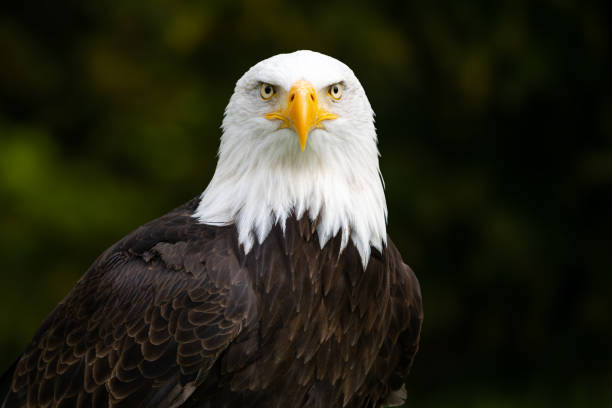

In [4]:
# Insert the URL of the image to load
url = "https://media.istockphoto.com/id/1369151591/photo/bald-eagle-with-blurred-green-background.jpg?s=612x612&w=0&k=20&c=awKaNCYd03Z9mGsEXL-fVRsP39161taL5naeAtPUtmY="

# Open and display the image
image = Image.open(requests.get(url, stream=True).raw)
image

In [5]:
# List of candidate labels for classification
candidate_labels = ["fox", "bear", "seagull", "owl", "eagle"]

# Generate predictions using the classification pipeline
predictions = detector(image, candidate_labels=candidate_labels)

In [6]:
# Extract labels and scores from the prediction results
labels = [pred['label'] for pred in predictions]
scores = [pred['score'] for pred in predictions]

# Select a color palette for the bars
colors = px.colors.qualitative.T10[:len(scores)]

# Create a horizontal bar chart to display the classification probabilities
fig = go.Figure(go.Bar(
    x=scores,
    y=labels,
    orientation='h',
    marker=dict(color=colors)
))

# Configure chart layout with titles and labels
fig.update_layout(
    title='Probabilities of Model Predictions',
    xaxis_title='Probability',
    yaxis_title='Classes',
    showlegend=False,
    plot_bgcolor='white',
    font=dict(
        family="Arial, sans-serif",
        size=14,
        color="black"
    )
)

# Display the chart
fig.show()

### **[EXTRA] OWL-ViT (aka Open-World Localization Vision Transformer)**

OWL-ViT is an open-vocabulary object detector. It means that it can detect objects in images based on free-text queries without the need to fine-tune the model on labeled datasets.

[Simple Open-Vocabulary Object Detection](https://link.springer.com/chapter/10.1007/978-3-031-20080-9_42) - Proceedings of the 17th European Conference on Computer Vision, 2022

#### **OWL-ViT Zero-Shot Object Detection**

OWL-ViT combines CLIP with lightweight object classification and localization heads. Open-vocabulary detection is achieved by embedding free-text queries with the text encoder of CLIP and using them as input to the object classification and localization heads.

<img src="https://drive.google.com/uc?export=view&id=1psqYu4gLrFfoR8zBwHM2R0EmTfA1mIDb" width="700"/>

In [7]:
# Select the model checkpoint for the pipeline
checkpoint = "google/owlv2-base-patch16-ensemble"

# Create the image classification pipeline and load the model
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

Device set to use cpu


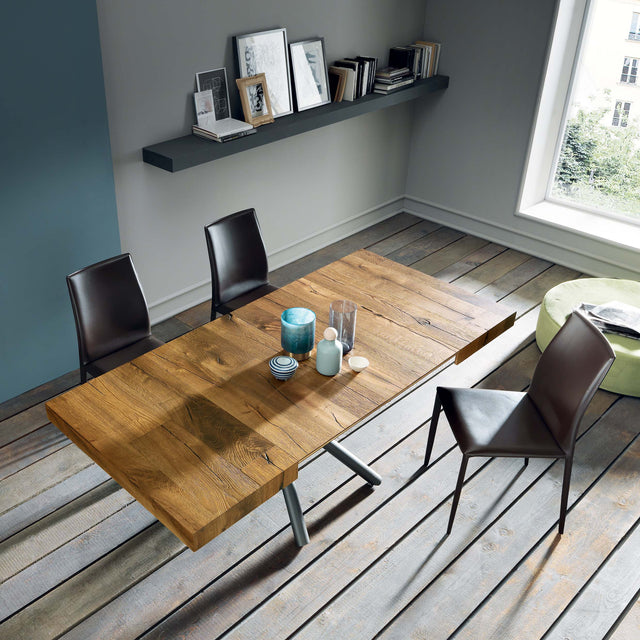

In [8]:
# Insert the URL of the image to load
url = "https://resourcefurniture.com/cdn/shop/files/Brooklyn_04_0a9ee0f6-4cae-4312-b241-1416787a231d.jpg?v=1676395934&width=640"

# Open and display the image
image = Image.open(requests.get(url, stream=True).raw)
image

In [9]:
# List of candidate labels for classification
candidate_labels = ["table", "chair", "glass", "shelf with items on it", "window"]

# Generate predictions using the classification pipeline
predictions = detector(image, candidate_labels=candidate_labels)
predictions

[{'score': 0.5544548630714417,
  'label': 'table',
  'box': {'xmin': 48, 'ymin': 250, 'xmax': 512, 'ymax': 554}},
 {'score': 0.46543088555336,
  'label': 'chair',
  'box': {'xmin': 430, 'ymin': 309, 'xmax': 617, 'ymax': 537}},
 {'score': 0.4616304337978363,
  'label': 'shelf with items on it',
  'box': {'xmin': 141, 'ymin': 75, 'xmax': 448, 'ymax': 173}},
 {'score': 0.4524480700492859,
  'label': 'chair',
  'box': {'xmin': 65, 'ymin': 251, 'xmax': 170, 'ymax': 384}},
 {'score': 0.44609853625297546,
  'label': 'glass',
  'box': {'xmin': 328, 'ymin': 299, 'xmax': 357, 'ymax': 355}},
 {'score': 0.4401179552078247,
  'label': 'chair',
  'box': {'xmin': 204, 'ymin': 207, 'xmax': 277, 'ymax': 323}},
 {'score': 0.3793974220752716,
  'label': 'window',
  'box': {'xmin': 523, 'ymin': 2, 'xmax': 639, 'ymax': 252}},
 {'score': 0.33057257533073425,
  'label': 'glass',
  'box': {'xmin': 279, 'ymin': 307, 'xmax': 316, 'ymax': 361}},
 {'score': 0.26964953541755676,
  'label': 'window',
  'box': {'xmi

In [10]:
# Set a threshold for prediction scores
threshold = 0.35

# Extract all unique labels with scores above the threshold and create a dynamic colour map
unique_labels = set(pred['label'] for pred in predictions if pred['score'] > threshold)
color_map = {label: cm.tab20(i / len(unique_labels)) for i, label in enumerate(unique_labels)}

# Convert colours from RGBA to hexadecimal for use in Plotly
color_map = {label: f"rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})" for label, rgba in color_map.items()}

# Initialise the plot with the same dimensions as the original image
fig = go.Figure(go.Image(z=np.array(image)))

# Configure the plot layout to match the size of the image
fig.update_layout(width=image.width, height=image.height, margin={"r":0,"t":0,"l":0,"b":0})

# Add bounding boxes and annotations based on predictions with scores above the threshold
for prediction in predictions:
    if prediction["score"] > threshold:
        box = prediction["box"]
        label = prediction["label"]
        score = prediction["score"]
        color = color_map.get(label, "white")

        # Add a shape for each bounding box
        fig.add_shape(
            type="rect",
            x0=box['xmin'], y0=box['ymin'],
            x1=box['xmax'], y1=box['ymax'],
            line=dict(color=color, width=2),
        )

        # Add an annotation for each label and score
        fig.add_annotation(
            x=box['xmin'], y=box['ymin'],
            text=f"{label}: {round(score, 2)}",
            showarrow=False,
            font=dict(color=color)
        )

fig.show()